In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from alibi.explainers import CounterFactual
from alibi.explainers import CounterFactualProto

Using TensorFlow backend.


#### Load eleven delta scuti stars

In [2]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)

stars = {}

# Select only one star
for s in df.take(11):  # take the 11 ds stars
    id = s[0].numpy()[0].decode("utf-8")
    print("DS star ID: ", s[0])
    target_class = np.where(s[2].numpy().flat == 1)[0].flat[0]
    print("Target class:", target_class)
    star = s[1].numpy()
    if id not in stars:
        stars[id] = {"target": target_class, "data": star}

print(stars.keys())

DS star ID:  tf.Tensor([b'KIC10080943'], shape=(1,), dtype=string)
Target class: 52
DS star ID:  tf.Tensor([b'CID105906206'], shape=(1,), dtype=string)
Target class: 20
DS star ID:  tf.Tensor([b'KIC8262223'], shape=(1,), dtype=string)
Target class: 77
DS star ID:  tf.Tensor([b'KIC9851944'], shape=(1,), dtype=string)
Target class: 26
DS star ID:  tf.Tensor([b'HD159561'], shape=(1,), dtype=string)
Target class: 38
DS star ID:  tf.Tensor([b'kic4544587'], shape=(1,), dtype=string)
Target class: 74
DS star ID:  tf.Tensor([b'CID100866999'], shape=(1,), dtype=string)
Target class: 56
DS star ID:  tf.Tensor([b'kic10661783'], shape=(1,), dtype=string)
Target class: 39
DS star ID:  tf.Tensor([b'HD15082'], shape=(1,), dtype=string)
Target class: 80
DS star ID:  tf.Tensor([b'KIC3858884'], shape=(1,), dtype=string)
Target class: 29
DS star ID:  tf.Tensor([b'HD172189'], shape=(1,), dtype=string)
Target class: 19
dict_keys(['KIC10080943', 'CID105906206', 'KIC8262223', 'KIC9851944', 'HD159561', 'kic45

### Load pretrained model saved from disk (whit TF eager deisabled)

In [3]:
tf.compat.v1.disable_eager_execution() # Disable eager to work with Alibi contrafactual
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_400")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 93, 10)            1

### Create a contrafactual prototype. 

- $\kappa$ : difference between the predicted probabilities for the perturbed instance of the original class and the max of the other classes. Must be increased in our case
- feature_range: Max and min values for perturbed instance. Is set up to [-0.2,1] allowing some negative values and all positive range values

In [14]:
cf = CounterFactualProto(
    sepconv_mod, kappa=0.01, feature_range=(0, 1), shape=(1, 406, 3), max_iterations=100
)

## Show original and closest contrafactual example

Processing star KIC10080943
Counterfactual prediction: 28


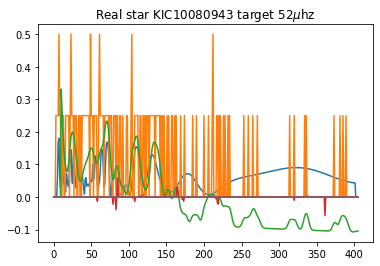

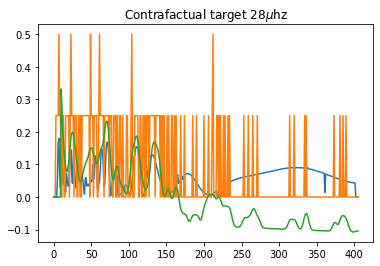

Processing star CID105906206
Counterfactual prediction: 28


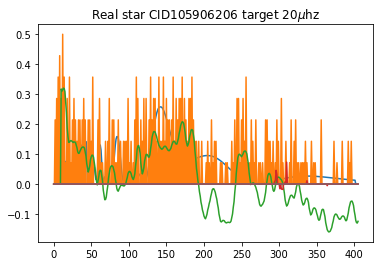

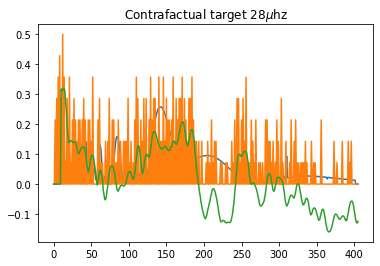

Processing star KIC8262223
Counterfactual prediction: 24


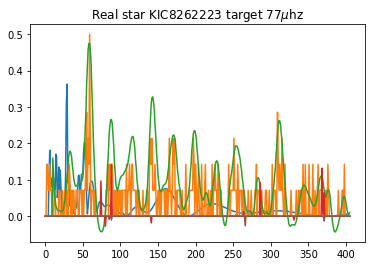

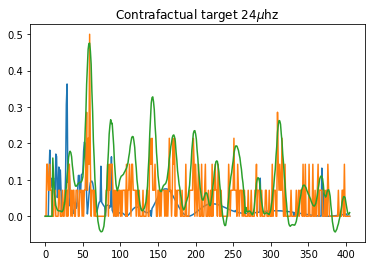

No counterfactual found!
Processing star KIC9851944
Skip star, no contrafactual found !
No counterfactual found!
Processing star HD159561
Skip star, no contrafactual found !
No counterfactual found!
Processing star kic4544587
Skip star, no contrafactual found !
Processing star CID100866999
Counterfactual prediction: 26


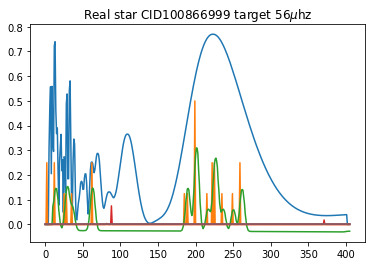

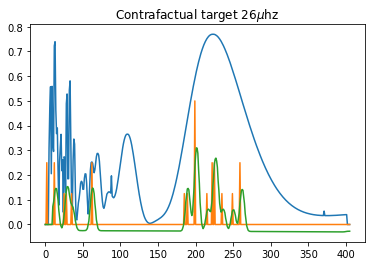

No counterfactual found!
Processing star kic10661783
Skip star, no contrafactual found !
No counterfactual found!
Processing star HD15082
Skip star, no contrafactual found !
Processing star KIC3858884
Counterfactual prediction: 26


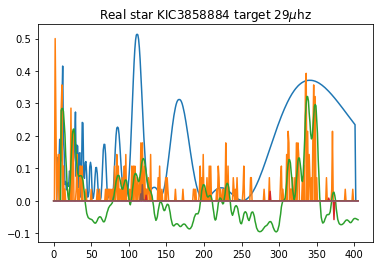

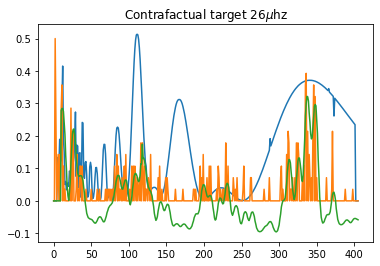

Processing star HD172189
Counterfactual prediction: 23


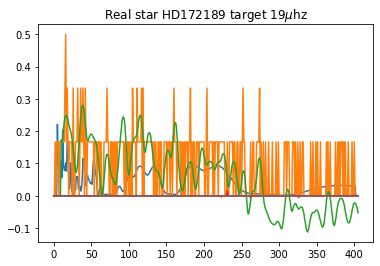

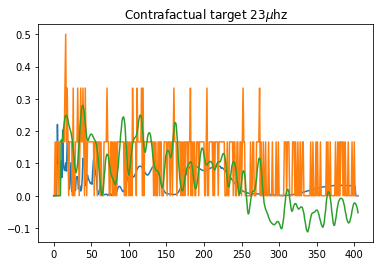

In [19]:
for id in stars:
    # Star data
    star = stars[id]["data"]
    # Explain by contrafactual
    explanation = cf.explain(
        star, k=1, target_class=[i for i in range(20, 30)], verbose=False
    )
    print("Processing star %s" % id)
    if explanation.cf is None:
        print("Skip star, no contrafactual found !")
    else:
        
        print('Counterfactual prediction: %s' % explanation.cf['class'])
        exp_data = explanation.cf['X']

        plt.plot(star[0, :, 0])
        plt.plot(star[0, :, 1])
        plt.plot(star[0, :, 2])
        plt.title(r'Real star %s target %s%s'% (id, stars[id]["target"], r'$\mu$hz'))

        plt.plot(exp_data[0, :, 0] - star[0, :, 0])
        plt.plot(exp_data[0, :, 1] - star[0, :, 1])
        plt.plot(exp_data[0, :, 2] - star[0, :, 2])
        plt.show()

        plt.plot(exp_data[0, :, 0])
        plt.plot(exp_data[0, :, 1])
        plt.plot(exp_data[0, :, 2])
        plt.title(r'Contrafactual target %s%s'% (explanation.cf['class'], r'$\mu$hz'))
        plt.show()